# Group Work

## 1 Background 
-Ruijue Song

words: 272

**From Strict Control to Deregulation**

Historically, London government restricted short-term lets in response to the shortage of affordable housing in the capital since 1973 (Sanyal and Ferreri, 2018). This changed decisively with the introduction of the Deregulation Act 2015. To encourage the growth of the sharing economy, the 90-day rule was introduced, which allows residents to rent out their spare rooms or entire houses on a short-term basis lawfully without planning permission. The government believed that it would enable Londoners to participate in the sharing economy and get financial benefits, boosting London's economy in turn.

**The Rise of Professional Landlords**

Airbnb, as a typical representative of the sharing economy, has successfully expanded from 14,000 listings in June 2015 to around 49,000 listings in October 2016 following this policy shift(data source: Inside Airbnb London). However, as the scales increased rapidly, Airbnb gradually deviated from its original purpose, from the idea of casual home-sharing to commercial operations. The emergence of a growing number of professional landlords who utilize entire properties as full-time hotels is exerting a significant negative influence on the stability of the London housing market (Gyódi, 2024). 

**Current Challenges**

There is a conflict between the commercialization of home-sharing and the original housing goals. Therefore, the opposition argued that Airbnb in London is "out of control" and proposed to force all professional landlords to register their properties and receive higher Council Tax rates. To inform future decisions, this report analyzes the current state of London Airbnb market and evaluates the likely impacts of the opposition's proposal. It also explores how we can turn this challenge into a positive narrative to strengthen public trust.

## 2 Data Pre-processing

words(without tittles): 391

下面的文字部分默认不放qmd里，代码前面有 #not in QMD 的不放QMD，是不影响数据清理、用于测试和提供分析数据的代码块

### 2.1 Loading the Dataset

In [58]:
#library packages
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from requests import get
from functools import wraps
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [59]:
# #not in QMD
# borough = gpd.read_file("data/raw/London_Borough_Excluding_MHW.shp")
# borough.to_file("London_Borough_Excluding.gpkg", driver="GPKG")

In [119]:
# read data from github URL
ymd  = "20250914"
city = "London"
host = "https://github.com/mixedmint/fsds_group/releases/download/airbnb"
url  = f'{host}/{ymd}-{city}-listings.csv.gz'


df = pd.read_csv(url, compression="gzip", low_memory=False)

In [121]:
#not in QMD
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#to view the full version of the charts below
pd.set_option('display.max_rows', 200) 
pd.set_option('display.max_columns', 200)
#to reset the display option
#pd.reset_option('display.max_rows')

### 2.2 Selecting Related Columns

First, let us have a look at the original data.

(我感觉这段可以保留到qmd里，先看一下原数据有多少，有什么columns）

In [122]:
#not in QMD
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,871 x 79


In [123]:
# not in QMD
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96871 entries, 0 to 96870
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96871 non-null  int64  
 1   listing_url                                   96871 non-null  object 
 2   scrape_id                                     96871 non-null  int64  
 3   last_scraped                                  96871 non-null  object 
 4   source                                        96871 non-null  object 
 5   name                                          96871 non-null  object 
 6   description                                   94421 non-null  object 
 7   neighborhood_overview                         41208 non-null  object 
 8   picture_url                                   96865 non-null  object 
 9   host_id                                       96871 non-null 

Then we select the columns that we will use in future analysis.
(Definitions are sourced from **Inside Airbnb's Data Dictionary**)

In [124]:
#select the needed columns
cols = ['id', 
        'listing_url', 
        'last_scraped', #UTC. The date and time this listing was "scraped"
        'name', 
        'host_id', 
        'host_name', 
        'host_since', #The date the host/user was created
        'host_location', 
        'host_is_superhost',
        'host_listings_count', #The number of listings the host has (per Airbnb unknown calculations)
        'latitude', #WGS84
        'longitude', 
        'property_type', #Hotels and Bed and Breakfasts are described as such by their hosts in this field
        'room_type', 
        'accommodates', #The maximum capacity of the listing
        'bathrooms', 
        'bedrooms', 
        'beds',
        'price',#daily price in local currency. 
        'minimum_nights', #minimum number of night stay for the listing (calendar rules may be different)
        'maximum_nights', 
        'availability_365', #avaliability_x. The availability of the listing x days in the future as determined by the calendar. 
        #Note a listing may not be available because it has been booked by a guest or blocked by the host.
        'number_of_reviews',#he number of reviews the listing has
        'number_of_reviews_ltm',#he number of reviews the listing has (in the last 12 months)
        'review_scores_rating',
        'reviews_per_month']

In [125]:
#not in QMD
print(f"Cols contains {len(cols)} columns.")

Cols contains 26 columns.


In [126]:
df = df[cols]

In [127]:
#not in QMD
df.sample(3, random_state=42)

,id,listing_url,last_scraped,name,host_id,host_name,host_since,host_location,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,reviews_per_month
56789,1001555573812356101,https://www.airbnb.com/rooms/1001555573812356101,2025-09-14,Luxury Modern Garden Studio |Gym Access| Studio S,520027398,Taiwo,2023-06-14,"London Borough of Barking and Dagenham, United...",f,3.00,51.54,0.12,Entire place,Entire home/apt,2,1.00,1.00,1.00,$78.00,1,365,355,101,46,4.57,4.42
4670,7160564,https://www.airbnb.com/rooms/7160564,2025-09-17,Sunny family house and large garden,9314436,Alice,2013-10-08,"London, United Kingdom",f,1.00,51.58,-0.11,Entire home,Entire home/apt,8,NaN,5.00,NaN,NaN,1,1125,0,0,0,NaN,NaN
29262,38201478,https://www.airbnb.com/rooms/38201478,2025-09-16,Super central Holborn London Luxurious 2beds flat,7757402,Chen,2013-07-27,"London, United Kingdom",f,2.00,51.52,-0.11,Entire condo,Entire home/apt,5,2.50,2.00,2.00,$306.00,5,20,16,9,4,4.89,0.23


### 2.3 Data Cleaning

To ensure the accuracy of our analysis, the dataset underwent the following processing steps:

1. **Handling Missing Data:** We removed null values in critical columns (e.g., `price`).

2. **Data Formatting:** We standardize data types, especially converting the price column from text (with '$' signs)to numeric format.

3. **Cleaning outliers:** We removed unrealistic values (e.g., minimum_nights exceeding 365 days), to filter out inactive or "ghost listings".

#### **Handling Missing Data**

In [128]:
#not in QMD 感觉这段可以保留，看一下有多少null values
#show the counts of null value of all columns
df.isnull().sum(axis=0).sort_values(ascending=False)[:12]

beds                     34920
price                    34908
bathrooms                34846
reviews_per_month        24122
review_scores_rating     24122
host_location            23771
bedrooms                 12775
host_is_superhost         1766
host_name                   43
host_since                  41
host_listings_count         41
number_of_reviews_ltm        0
dtype: int64

In [129]:
#delete the rows with more than 5 null columns
probs = df.isnull().sum(axis=1)
cutoff = 5
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"df contains {df.shape[0]:,} rows after removing null values.")

df contains 90,674 rows after removing null values.


**#这段是不是放到out of control那，筛misuse的时候再看比较好？**

检查property_type和room_type的类别情况：
需要注意，我们说的entire是指room_type的Entire home/apt，而property_type主要用于分析后面airbnb房源聚集区域与property类别？（比如筛选出整栋别墅等，这类房源的房东如果从airbnb中获得大量收入，其实是不利于airbnb本身的初衷和社会住房公平的）

**(notes from the meta data dictionary)the definition of different room_type:**
[Entire home/apt|Private room|Shared room|Hotel]

All homes are grouped into the following three room types:

Entire place
Entire places are best if you're seeking a home away from home. With an entire place, you'll have the whole space to yourself. This usually includes a bedroom, a bathroom, a kitchen, and a separate, dedicated entrance. Hosts should note in the description if they'll be on the property or not (ex: "Host occupies first floor of the home"), and provide further details on the listing.

Private rooms
Private rooms are great for when you prefer a little privacy, and still value a local connection. When you book a private room, you'll have your own private room for sleeping and may share some spaces with others. You might need to walk through indoor spaces that another host or guest may occupy to get to your room.

Shared rooms
Shared rooms are for when you don't mind sharing a space with others. When you book a shared room, you'll be sleeping in a space that is shared with others and share the entire space with other people. Shared rooms are popular among flexible travelers looking for new friends and budget-friendly stays.

In [130]:
#not in QMD
#check the categories inside 'property_type','room_type'
cats = ['property_type','room_type']
#the categories in property_type:
df[cats[0]].value_counts()

property_type
Entire rental unit                    40146
Private room in rental unit           11831
Private room in home                  10193
Entire home                            8899
Entire condo                           8171
Private room in condo                  3028
Entire serviced apartment              1843
Private room in townhouse              1104
Entire townhouse                       1046
Room in hotel                           946
Private room in bed and breakfast       456
Private room in guesthouse              346
Entire loft                             332
Entire guesthouse                       216
Room in boutique hotel                  199
Entire guest suite                      170
Private room in guest suite             165
Private room in loft                    143
Private room in serviced apartment      125
Room in aparthotel                       89
Entire villa                             79
Private room                             70
Boat              

In [131]:
#not in QMD
#the categories in room_type:
df[cats[1]].value_counts()

room_type
Entire home/apt    61455
Private room       28903
Shared room          208
Hotel room           108
Name: count, dtype: int64

#### **Fixing Data Types**

1. Categories

In [132]:
cats = ['property_type','room_type']
for c in cats:
    df[c] = df[c].astype('category')

In [133]:
#not in QMD
df.sample(5, random_state=43)[cats]

,property_type,room_type
79337,Entire rental unit,Entire home/apt
89854,Room in hotel,Private room
19781,Entire rental unit,Entire home/apt
50452,Entire rental unit,Entire home/apt
30795,Entire rental unit,Entire home/apt


In [134]:
#not in QMD
print(f"Now {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")

Now room_type is of type 'category' 



2. Boolean Values

In [135]:
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost


In [136]:
#not in QMD
df.sample(5, random_state=43)[bools]

,host_is_superhost
79337,False
89854,False
19781,False
50452,False
30795,False


In [137]:
#not in QMD
print(f"Currently {bools[0]} is of type '{df[bools[0]].dtype}'", "\n")

Currently host_is_superhost is of type 'bool' 



3. Dates

In [138]:
dates = ['last_scraped','host_since']
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])

Converting last_scraped
Converting host_since


In [139]:
#not in QMD
df.sample(5, random_state=43)[dates]

,last_scraped,host_since
79337,2025-09-15,2016-07-07
89854,2025-09-16,2018-02-23
19781,2025-09-15,2012-05-02
50452,2025-09-16,2015-02-16
30795,2025-09-17,2017-07-18


In [140]:
#not in QMD
print(f"Currently {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")

Currently host_since is of type 'datetime64[ns]' 



4. Integers

In [141]:
ints  = ['id','host_id','host_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365','number_of_reviews',
        'number_of_reviews_ltm']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365
Converting number_of_reviews
Converting number_of_reviews_ltm


5. Strings

In [142]:
money = ['price']
for m in money:
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

In [143]:
#not in QMD
df.sample(5, random_state=43)[money]

,price
79337,188.00
89854,96.00
19781,119.00
50452,397.00
30795,NaN


In [144]:
#not in QMD
print(f"Currently {money[0]} is of type '{df[money[0]].dtype}'", "\n")

Currently price is of type 'float64' 



Finally, check the datatypes after converting.

In [145]:
#not in QMD
#validation
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90674 entries, 0 to 96870
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     90674 non-null  int64         
 1   listing_url            90674 non-null  object        
 2   last_scraped           90674 non-null  datetime64[ns]
 3   name                   90674 non-null  object        
 4   host_id                90674 non-null  int64         
 5   host_name              90661 non-null  object        
 6   host_since             90663 non-null  datetime64[ns]
 7   host_location          69534 non-null  object        
 8   host_is_superhost      90674 non-null  bool          
 9   host_listings_count    90663 non-null  UInt16        
 10  latitude               90674 non-null  float64       
 11  longitude              90674 non-null  float64       
 12  property_type          90674 non-null  category      
 13  room_t

#### **Cleaning Outliers**

1. `Price`

First, have a look at the descriptive statistics of `price` column.

In [146]:
#not in QMD
df['price'].map('{:.2f}'.format)
df['price'].describe()

count     61949.00
mean        229.87
std        4438.05
min           7.00
25%          77.00
50%         135.00
75%         221.00
max     1085147.00
Name: price, dtype: float64

The descriptive statistics revealed extreme outliers in `price` column, with a maximum value of \$1,085,147, which is clearly incorrect data. 

To ensure data integrity, we filtered out listings priced over **\$3,000**, excluding probable errors while retaining luxury listings.

In [147]:
df = df[df['price'] <= 3000]

In [148]:
#not in QMD
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 61,781 x 26


In [149]:
#not in QMD
df['price'].describe()

count   61781.00
mean      185.67
std       198.19
min         7.00
25%        77.00
50%       135.00
75%       220.00
max      3000.00
Name: price, dtype: float64

2. `host_listings_count`

In [150]:
#not in QMD
df['host_listings_count'].describe()

count   61770.00
mean       68.06
std       481.01
min         1.00
25%         1.00
50%         3.00
75%        17.00
max      5469.00
Name: host_listings_count, dtype: Float64

We observed the maximum value of `host_listings_count` is 5469. While the figure is extreme, it likely represents large-scale property management companies in London. Rather than excluding these high values, we retained them as they are the most significant evidence of sharing economy commercialization and the existence of professional hosts, which are the central of the opposition's argument that Airbnb in London is "out of control".

3. `minimum_nights`

In [151]:
#not in QMD
df['minimum_nights'].describe()

count   61781.00
mean        4.99
std        18.15
min         1.00
25%         1.00
50%         2.00
75%         3.00
max       999.00
Name: minimum_nights, dtype: float64

We would like to exclude listings with a `minimum_nights` value exceeding **365 days**. While long-term rentals do exist, a minimum booking requirement of more than one year is atypical for the Airbnb platform and inconsistent with the standard tenancy contracts (usually 6-12 months). Thus, we identified these listings as likely **"ghost listings"**, where hosts intentionally set prohibitive minimum booking requirements to block bookings without deleting listings, and removed them to ensure our analysis not affected by these inactive listings.

In [152]:
df = df[df['minimum_nights'] < 365]

In [153]:
#not in QMD
df['minimum_nights'].describe()

count   61748.00
mean        4.77
std        15.16
min         1.00
25%         1.00
50%         2.00
75%         3.00
max       364.00
Name: minimum_nights, dtype: float64

4. `maximum_nights`

In [154]:
#not in QMD
df['maximum_nights'].describe()

count       61748.00
mean         8912.78
std       2112165.83
min             1.00
25%            90.00
50%           365.00
75%           365.00
max     524855552.00
Name: maximum_nights, dtype: float64

We did not apply up-limit filtering to the `maximum_nights`, because high values in this column typically indicates the default platform settings with on restrictions on length of stay. Unlike the `minimum_nights`, the high `maximum_nights`values are not invalid data which restricts booking accessibility or indicates inactive listings.

5. `availability_365`

In [155]:
#not in QMD **我觉得这部分可以放进qmd，当做检查数据完整性**
df['availability_365'].describe()

count   61748.00
mean      214.32
std       121.88
min         0.00
25%        91.00
50%       242.50
75%       334.00
max       365.00
Name: availability_365, dtype: float64

6. `number_of_reviews`

In [156]:
#not in QMD 可以放吧，看一下一共有多少评论
df['number_of_reviews'].describe()

count   61748.00
mean       27.00
std        58.33
min         0.00
25%         1.00
50%         7.00
75%        27.00
max      1902.00
Name: number_of_reviews, dtype: float64

number_of_reviews_ltm:

In [157]:
#not in QMD
df['number_of_reviews_ltm'].describe()

count   61748.00
mean        8.05
std        13.89
min         0.00
25%         0.00
50%         2.00
75%        10.00
max       390.00
Name: number_of_reviews_ltm, dtype: float64

review_scores_rating:

In [158]:
#not in QMD
df['review_scores_rating'].describe()

count   47972.00
mean        4.67
std         0.51
min         1.00
25%         4.57
50%         4.82
75%         5.00
max         5.00
Name: review_scores_rating, dtype: float64

7. `reviews_per_month`

In [159]:
#not in QMD **可以放进去吧**
df['reviews_per_month'].describe()

count   47972.00
mean        1.28
std         1.42
min         0.01
25%         0.33
50%         0.83
75%         1.73
max        36.96
Name: reviews_per_month, dtype: float64

We identified and removed listings with a `reviews_per_month` value more than **31**. Since a single property can accommodate at most one booking per night, receiving more than 31 reviews per month is impossible (a month has a maximum of 31 days). These outliers likely represent hotel inventories (where one hotel has multiple rooms) or data calculation artifacts. By removing them, we can make sure our analysis focus on the residential listings.

In [160]:
df = df[df['reviews_per_month'] <= 31]

In [161]:
df['reviews_per_month'].describe()

count   47971.00
mean        1.28
std         1.41
min         0.01
25%         0.33
50%         0.83
75%         1.73
max        26.02
Name: reviews_per_month, dtype: float64

#reviews_per_month(calculated by inside airbnb)：
The average number of reviews per month the listing has over the lifetime of the listing.

Psuedocoe/~SQL:

IF scrape_date - first_review <= 30 THEN number_of_reviews
ELSE number_of_reviews / ((scrape_date - first_review + 1) / (365/12))

In [162]:
#not in QMD 可以保留吧
print(f"Data frame after data cleaning has {df.shape[0]:,} rows x {df.shape[1]} columns")

Data frame after data cleaning has 47,971 rows x 26 columns


## 3 Overview of the London Airbnb Market

word: 175

#研究范围等级：
LA = Local Authority（地方行政区）
在 London 指的是 伦敦32个 Borough + City of London（共33个）

1 airbnb listing规模：
（1）airbnb房源数量=数据的行数（我们的数据是2025年9月的）
（2）london所有房源数量(因为后面out of control我觉得要用到分区的数据，所以比起2023年全伦敦的数据，研究还是选择使用2021年的分区census数据)

**用了这个数据：需要标注**
2021年分区的房源数据
https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/numberofdwellingsbyhousingcharacteristicsinenglandandwales

**参考但没使用**2023年的伦敦总房源数据https://www.london.gov.uk/sites/default/files/2024-11/London%27s%20Housing%20Stock%20-%20Research%20Unit%20-%20November%202024.pdf)

gpt：
We use 2021 Census dwelling counts at the Local Authority level as the most authoritative and consistent measure of housing stock. Although our Airbnb data is from 2025, housing stock changes relatively slowly at the borough level, so the time mismatch is unlikely to materially distort percentage estimates. As a sensitivity check, we also compare with GLA 2024 city-wide dwelling stock (3.79m).
（3）总占比

2.airbnb的空间分布图
（1）listings点分布图
（2）按某个行政区范围（比如LA?）汇总listings点数量，绘制以listings的sum为数值的分布图，以及各个room type的占比


*关于论文里misuse的房子的定义:listings是entire的(room_type == Entire home/apt)且availablity_365大于180天且minimum_nights<=90且房东有多套房源
the proportion of **entire Airbnb properties** according to the **annual availability (if listings are available for more than 180 days)**, as well as whether the hosts have **multiple listings** – indicating possible misuse.

### 3.1 The Scale of Airbnb listings

In [163]:
#Amount of total Airbnb listing
n_airbnb = df.shape[0]
print("Total Airbnb listings:", n_airbnb)

Total Airbnb listings: 47971


In [164]:
#Loading London housing data
url_housing = "https://github.com/mixedmint/fsds_group/releases/download/housing/Dwelling.occupancy.England.and.Wales.2021.csv"
df_housing = pd.read_csv(url_housing, low_memory=False)

In [165]:
#Calculating the proportion of Aribnb listings in London's total listings
london_total_house = (
    df_housing.loc[
        df_housing["Area Name"] == "London",
        "Total: All dwellings (excluding communal establishments)"
    ]
    .iloc[0]              
    .replace(",", "")    
)

london_total_house = int(london_total_house)
london_total_house

airbnb_share = n_airbnb / london_total_house * 100
print(f"The proportion of Airbnb listings in London’s total housing stock is {airbnb_share:.2f}%")

The proportion of Airbnb listings in London’s total housing stock is 1.29%


### 3.2 The Spatial Distribution of Airbnb Listings

In [166]:
#Loading London boundary data
url_boro = "https://github.com/mixedmint/fsds_group/releases/download/data_boro/London_Borough_Excluding.gpkg"
boros = gpd.read_file(url_boro).to_crs(27700)

In [167]:
# Create geometry column of Airbnb data
df["geometry"] = gpd.points_from_xy(df.longitude, df.latitude)
gdf_airbnb = gpd.GeoDataFrame(df, geometry="geometry", crs=4326)

# convert to BNG for London
gdf_airbnb = gdf_airbnb.to_crs(27700)

让gpt做了个比例尺函数，后面作图请用

In [168]:
#scalebar function *using ChatGPT
def add_scalebar(ax, length=5000, location=(0.05, 0.05), bar_height=500):
    """
    Add a black-white alternating bar scale (units in meters for BNG projection EPSG:27700)
    length: total length of scale bar in meters
    bar_height: height of the bar in map units (meters)
    """
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()

    sb_x = x0 + (x1 - x0) * location[0]
    sb_y = y0 + (y1 - y0) * location[1]

    # number of segments (use 2 or 4 typically)
    segments = 4
    segment_length = length / segments

    for i in range(segments):
        ax.add_patch(plt.Rectangle(
            (sb_x + i * segment_length, sb_y),
            segment_length,
            bar_height,
            facecolor='black' if i % 2 == 0 else 'white',
            edgecolor='black'
        ))

    # Draw text label
    ax.text(
    sb_x + length / 2,          
    sb_y + bar_height + 300,    
    f"{int(length/1000)} km",
    fontsize=10,
    ha="center",                
    va="bottom"                  
)

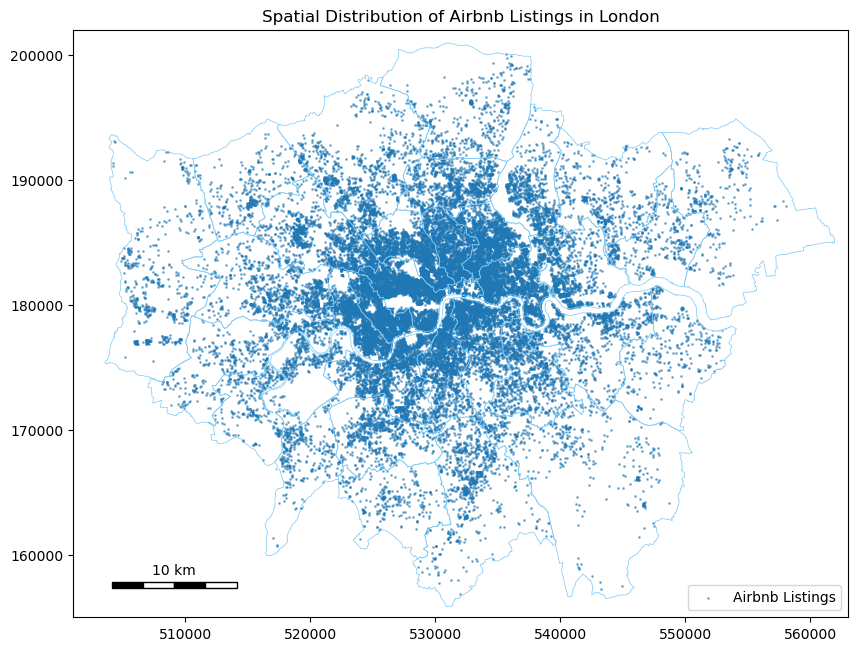

In [169]:
#Mapping
fig, ax = plt.subplots(figsize=(10,10))
gdf_airbnb.plot(ax=ax, markersize=1, alpha=0.5,label="Airbnb Listings")  
boros.plot(ax=ax, edgecolor='xkcd:lightblue',facecolor='none',linewidth=0.5) 
# Set the x and y limits
ax.set_xlim(501000, 563000)
ax.set_ylim(155000, 202000)

ax.set_title("Spatial Distribution of Airbnb Listings in London")

ax.legend(loc="lower right")
add_scalebar(ax, length=10000) 

The scatter map reveals the distinct **core-periphery pattern** of Airbnb listings in London. Listings are unevenly distributed, **forming a high-density cluster in inner London**, particularly along the River Thames, which is the core tourist and commercial area. By contrast, the distribution in outer London appears much sparser. This pattern suggests that **the short-term rental market is primarily driven by tourism demand**, creating disproportionate pressure on housing stock in the city center.

Next, we analyzed the spatial density distribution of Airbnb listings across all boroughs.

In [171]:
#Spatial join the airbnb and boroughs data
joined = gpd.sjoin(gdf_airbnb, boros, how="left", predicate="within")

#get the sum of Airbnb listings in every borough
airbnb_by_boros = joined.groupby("NAME")[["geometry"]].count().reset_index()
airbnb_by_boros.columns = ["NAME", "n_listings"]

boros = boros.merge(airbnb_by_boros, on="NAME", how="left")
boros["n_listings"] = boros["n_listings"].fillna(0)

In [172]:
#calculating the area
boros["area_km2"] = boros.geometry.area / 1e6
#calculating the density
boros["density"] = boros["n_listings"] / boros["area_km2"]

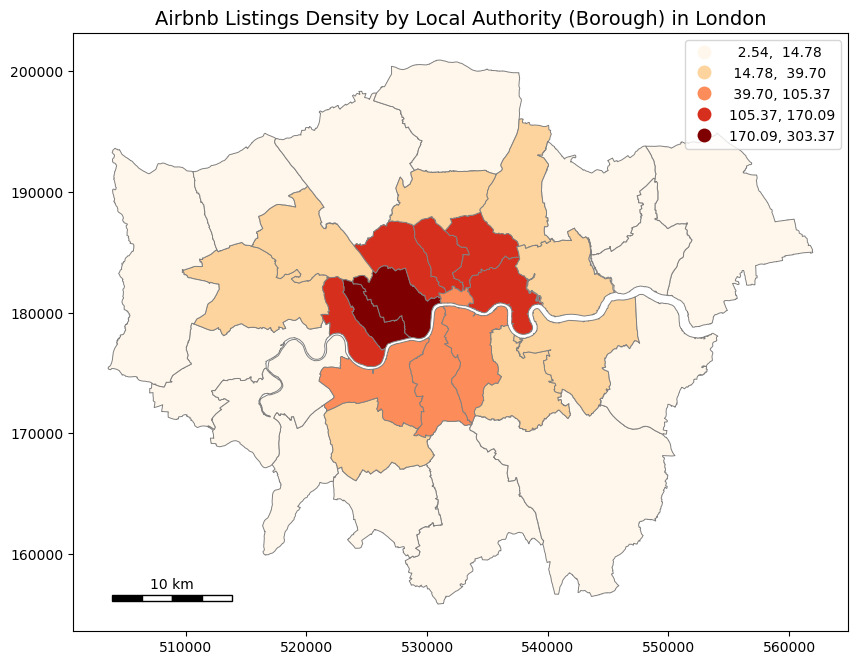

In [175]:
#maping
fig, ax = plt.subplots(figsize=(10,10))

boros.plot(column="density",
            cmap="OrRd",
            linewidth=0.7,
            edgecolor="grey",
            legend=True,
            scheme="natural_breaks",
            ax=ax)

ax.set_title("Airbnb Listings Density by Local Authority (Borough) in London", fontsize=14)

add_scalebar(ax, length=10000)

plt.show()

As shown in the map, the Airbnb market is not evenly distributed. The highest density of listings is found in **Kensington and Chelsea** and **Westminster**, where the density is significantly higher than in other boroughs. A second tier of high density covers **Hammersmith and Fulham, Camden, Islington, Hackney and Tower Hamlets**-all located north of the River Thames. These boroughs represent London's core tourism and commercial hubs. The high densities reflect strong visitor demand but also highlight where the conflict between residential housing needs and short-term tourism accommodation is likely most acute.

## 4 Is Airbnb in London out of control?

### 4.1 How to define "out of control"
hard to define directly →
cause it is used to describe the whole London area, which is large. And there is no related standards for reference (e.g. 30% of Airbnb houses London are priced above 1000$/night can be treated as out of control)→
so we introduce the concept of "misuse", which is much easier to implement, because it describes whether a samller unit: a single property is legally operated (90 days etc) →
we use how many properties are misused to help us find out whther London Airbnb Marker is out of control

### 4.2 How many properties are misused?

### 4.3 The distribution patterns of misused properties

### 4.4 The influence of Airbnb misuses
for housing rent? or other factors

### 4.5 Conclusion: **Airbnb in London is out of control !**

## 5 How many professional landlords are there?
-Code: Qiuli Li; Description context: Ruijue Song

### 5.1 How to define professional landlords
The landlords who own 2 or more entire houses and rent them out on Airbnb for more than 90 days a year.

### 5.2 How many professional landlords in London

In [51]:
top_hosts = (
    df.groupby(['host_id', 'host_name'])
      .size()
      .reset_index(name='n_listings')
      .sort_values(by='n_listings', ascending=False)
)

top_hosts.head(20)

,host_id,host_name,n_listings
27242,577866564,A,48
22654,452703305,Leslie,48
7742,27572615,Harry,48
17648,204935083,Matthew,48
10603,49472260,Josh,47
9946,43754868,Silvia,47
18237,227297499,Djamshed,46
11923,64995499,Adam,46
18215,226573050,Amanullah,46
14603,112868447,Alex,45


### 5.3 Where are these professional landlords distributed

### 5.4 Conclusion


## 6 How many properties would be affected by the opposition’s proposal?
-Code: Qiuli Li; Description context: Ruijue Song

### 6.1 What kind of properties would be affected?
The properties would be affected: **in hot-sopt districts, professional hosts, entire house**

### 6.2 How many properties would be affected in London

### 6.3 Conclusion

## 7 What are the likely pros and cons of the opposition’s proposal? 
-Jiajun Zhong

### 7.1 Pros of the proposal

#### For the Mayor

#### For the Residents

#### For the City

### 7.2 Cons of the proposal
same structure as pros

#### For the Mayor

#### For the Residents

#### For the City

## 8 Can the story be reframed as a positive one about social mobility or housing opportunity?
-Jiajun Zhong

### 8.1 增加居民/non-professional hosts 收入

关于营业额计算，来自gpt： 可以根据 reviews 推算 occupancy → 估算 revenue，这正是全世界 Airbnb 研究论文都在做的。

著名论文： Wachsmuth & Weisler (2018) "The High Cost of Short-Term Rentals in New York City" Barron, Kung & Proserpio (2021) “Airbnb and Housing Rents” Inside Airbnb 官方 methodology

核心假设（全世界论文通用）： 大约 50–70% 的 Airbnb 住客会留下 review。所以： reviews_per_month / 0.5 ≈ bookings per month bookings * price ≈ revenue

也就是说：如果一个 listing 每月有 2 条评论，假设每 2 个住客有 1 个给评论（50% review rate）→ 真实入住次数大约是 4 次 再结合： price（每晚价格） minimum_nights（最低入住天数） 平均入住天数 = 文献一般假设 3–5 nights 就可以估算营业额。

房东实际收入=营业额-(每次的)清洁费*次数

### 8.2

### 8.3

## 9 Reference

[1] Airbnb and its potential impact on the London housing market [WWW Document], n.d. https://doi.org/10.1177/0042098020970865

[2] HM Government United Kingdom (2015a) Deregulation act 2015. Available at: https://www.legislation.gov.uk/ukpga/2015/20/contents

[3] Platform economies and urban planning: Airbnb and regulated deregulation in London [WWW Document], n.d. https://doi.org/10.1177/0042098017751982

[4] Gyódi, K., 2024. The spatial patterns of Airbnb offers, hotels and attractions: are professional hosts taking over cities? Current Issues in Tourism 27, 2757–2782. https://doi.org/10.1080/13683500.2023.2239428

[5] https://www.london.gov.uk/programmes-strategies/housing-and-land/buying-and-owning-home/guidance-short-term-and-holiday-lets-london